# 모두를 위한 딥러닝 시즌2 - TensorFlow

## LAB07-6 - IMDB-introduction

CUAI 강민기

### IMDB 분류 모델 생성 

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(777)
print(tf.__version__)

2.5.0


### 학습에 쓰이는 Data
=50000 movie review from the Internet Movie Database (10000개의 빈도수가 높은 단어를 학습시 Vector에 사용)

*리뷰텍스트는 어휘 사전의 특정 단어를 나타내는 정수로 변환되어 있음.*

In [19]:
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)#num_words=10000 : 훈련데이터에서 가장 많이 등장하는 상위 100000개의 단어 선택
print("Training entries : {}, labels : {}".format(len(train_data),len(train_labels)))
print(train_data[0])

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\anan\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


Training entries : 25000, labels : 25000
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


C:\anan\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


#### IMDB Data를 Vector을 실재 값으로 변환해 출력

정수를 단어로 다시 변환한다.   
: 정수와 문자열을 매핑한 딕셔너리 객체에 질의하는 헬퍼 함수를 만들기

In [20]:
#단어와 정수 인덱스를 매핑한 딕셔너리
word_index = imdb.get_word_index()

word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"]=0
word_index["<START>"]=1
word_index["<UNK>"]=2 #unknow이란 뜻
word_index["<UNUSED>"]=3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i,'?') for i in text])

decode_review(train_data[4])

"<START> worst mistake of my life br br i picked this movie up at target for 5 because i figured hey it's sandler i can get some cheap laughs i was wrong completely wrong mid way through the film all three of my friends were asleep and i was still suffering worst plot worst script worst movie i have ever seen i wanted to hit my head up against a wall for an hour then i'd stop and you know why because it felt damn good upon bashing my head in i stuck that damn movie in the <UNK> and watched it burn and that felt better than anything else i've ever done it took american psycho army of darkness and kill bill just to get over that crap i hate you sandler for actually going through with this and ruining a whole day of my life"

In [21]:
print(train_labels[4])

0


### Tensorflow Keras
위 Data를 기준으로 분류 모델을 만들기
- 학습과 평가를 위해 동일길이인 256길이의 단어로 PAD 값을 주어 맞춰줌(뒤의 길이는 0값으로 맞춰줌!)

*데이터 준비: 리뷰-정수 배열은 신경망에 주입 전 텐서로 변환되어야 함.*   
*그리고 신경망의 입력은 영화리뷰의 길이가 같아야 한다. 변환 방법은 두가지가 있고*
1. 원-핫 인코딩 : 정수배열을 0, 1로 이루어진 벡터로 변환
2. 정수 배열의 길이가 모두 같도록 padding을 추가해 max_length*num_reviews 크기의 정수 텐서를 만듦.


In [22]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                       value = word_index["<PAD>"],
                                                       padding = 'post',
                                                       maxlen=256)
test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                      value=word_index["<PAD>"],
                                                      padding='post',
                                                      maxlen=256)
print(len(train_data[0]), len(test_data[0]))
print(train_data[0]) #패딩된 첫 번째 리뷰 내용 확인

256 256
[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  10

### 모델 구성


- Tensorflow Keras API를 통해 모델에 대한 정의
- 입력 SIZE와 학습시킬 Layer의 크기와 Activation Function에 대한 정의

1) 모델에서 얼마나 많은 층을 사용할 것인지   
2) 각 층에서 얼마나 많은 은닉 유닛을 사용할 것인지 결정!   
입력 데이터가 단어 인덱스의 배열, 예측할 레이블은 0또는 1.

1. 첫 번째 층 : 임베딩 층 : 정수로 인코딩된 단어를 입력 받고 각 단어 인데스에 해당하는 임베딩 벡터찾기   
2. 두 번째 층 : GlobalAveragePooling1D 층: sequence 차원에 대해 평균을 계산해 각 샘플에 대해 고정된 길이의 출력 벡터를 반환   
3. 세 번째 층 : 완전 연결층   
4. 네 번째 층 : 하나의 출력노드를 가진 완전 연결층 : sigmoid 함수 이용해 0,1 사이의 실수 출력

In [23]:
#입력 크기: 영화 리뷰 데이터셋에 적용된 어퓌 사전의 크기
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1,activation=tf.nn.sigmoid))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


- Adam Optimizer과 Cross Entropy Loss 선언

In [24]:
model.compile(optimizer='adam',
             loss = 'binary_crossentropy', #batch_crossentropy 손실함수 사용
             metrics=['accuracy'])

### 검증 세트 만들기
- 모델을 평가할 Test 데이터에 대한 정의 (10000을 기준으로 학습과 평가 수행)


In [25]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

### 모델 훈련
모델을 미니배치(512개의 샘플로 이루어진)에서 40번 에포크동안 훈련

In [26]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs = 40,
                   batch_size = 512,
                   validation_data = (x_val, y_val),
                   verbose = 1)

Epoch 1/40
30/30 [==============================] - 1s 18ms/step - loss: 0.6923 - accuracy: 0.5355 - val_loss: 0.6906 - val_accuracy: 0.6589
Epoch 2/40
30/30 [==============================] - 0s 16ms/step - loss: 0.6873 - accuracy: 0.7129 - val_loss: 0.6835 - val_accuracy: 0.7414
Epoch 3/40
30/30 [==============================] - 0s 15ms/step - loss: 0.6762 - accuracy: 0.7564 - val_loss: 0.6693 - val_accuracy: 0.7444
Epoch 4/40
30/30 [==============================] - 0s 14ms/step - loss: 0.6561 - accuracy: 0.7729 - val_loss: 0.6461 - val_accuracy: 0.7646
Epoch 5/40
30/30 [==============================] - 0s 15ms/step - loss: 0.6255 - accuracy: 0.7867 - val_loss: 0.6132 - val_accuracy: 0.7778
Epoch 6/40
30/30 [==============================] - 0s 16ms/step - loss: 0.5856 - accuracy: 0.8049 - val_loss: 0.5741 - val_accuracy: 0.7979
Epoch 7/40
30/30 [==============================] - 0s 16ms/step - loss: 0.5397 - accuracy: 0.8227 - val_loss: 0.5312 - val_accuracy: 0.8146
Epoch 8/40
30

### 모델 평가
손실과 정확도 반환

In [27]:
results = model.evaluate(test_data, test_labels)
print(results) #87%정도의 정확도 달성

782/782 [==============================] - 1s 828us/step - loss: 0.3261 - accuracy: 0.8730
[0.32612812519073486, 0.8729599714279175]


*이 부분은 추가!*
### 정확도와 손실 그래프 그리기

In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
import matplotlib.pyplot as plt

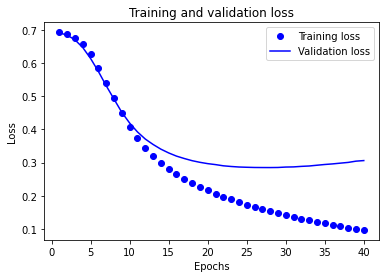

In [30]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# bo : 파란색 점
plt.plot(epochs, loss, 'bo', label='Training loss')
# b : 파란 실선
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

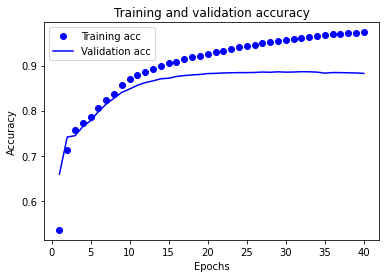

In [31]:
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

훈련 손실은 에포크마다 감소하고 훈련 정확도는 증가한다.
- Validation loss 와 Validation accuracy는 20번째 에포크 이후가 최적점 => 이게 과대적합 떄문이다.=> 막기 위해선 20번째에서 에포크 멈추면 됨.